In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_candidates_work_places = pd.read_csv('C:/Users/danii/skolkovo-hack/data/data_candidates_work_places.csv', sep=';',
                                names = ['CandidateId', 'Position','FromYear', 'FromMonth', 'ToYear', 'ToMonth'])
data_jobs = pd.read_csv('C:/Users/danii/skolkovo-hack/data/data_jobs.csv', sep=';',
                                names = ['JobId', 'Status','Name', 'Region', 'Description'])
data_candidates = pd.read_csv('C:/Users/danii/skolkovo-hack/data/data_candidates.csv', sep=';',
                                names = ['CandidateId', 'Position','Sex', 'Citizenship', 'Age',
                                'Salary', 'Langs', 'DriverLicense', 'Subway', 'Skills', 'Employment', 'Shedule', 
                                'CandidateRegion', 'DateCreated', 'JobId', 'CandidateStatusId', 'Status'], )
data_candidates_education = pd.read_csv('C:/Users/danii/skolkovo-hack/data/data_candidates_education.csv', sep=';',
                                names = ['CandidateId', 'University', 'Faculty', 'GraduateYear'])

In [4]:
def del_stick(text):
    if type(text) == type(''):
        return ''.join(text.split('||'))
    return text


data_candidates.Skills = data_candidates.Skills.apply(del_stick)

In [5]:
import re
 
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|-|/|;|_|•')
 
def cleanhtml(raw_html):
    if type(raw_html) == type(''):
        return re.sub(CLEANR, '', raw_html)
    return raw_html
 
data_jobs.Description = data_jobs.Description.apply(cleanhtml)

In [6]:
sns.set_theme(
    font_scale = 1.3,
    style = 'whitegrid',
    rc = {'figure.figsize' : (20, 10)}
)

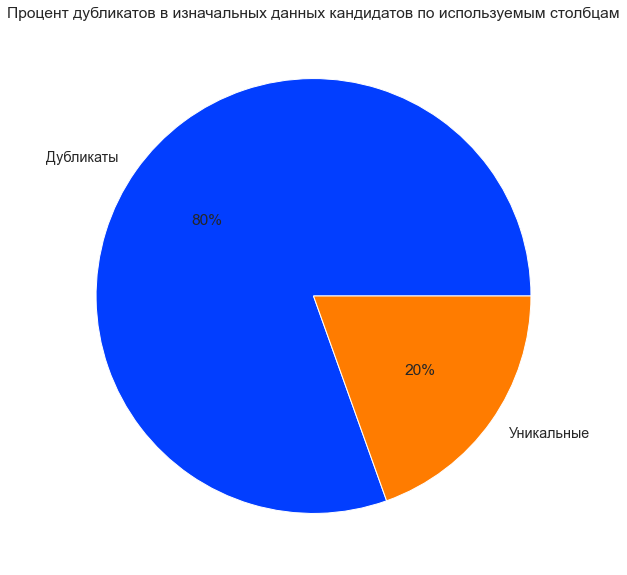

In [7]:
num_duplicates = data_candidates.duplicated(['Position', 'Age', 'Employment', 'Shedule', 'CandidateRegion', 
                            'Langs', 'Sex', 'Citizenship', 'DriverLicense', 'Skills'])\
                                                                                    .sum()
colors = sns.color_palette('bright')[0:2]
pie_plot = plt.pie([num_duplicates, data_candidates.shape[0] - num_duplicates], labels = ['Дубликаты', 'Уникальные'], 
        colors = colors, autopct='%.0f%%')
plt.title('Процент дубликатов в изначальных данных кандидатов по используемым столбцам')
plt.savefig('pie_plot.png')

In [8]:
cols_val = {str(i): 'last' for i in data_candidates.columns}

In [9]:
grouped_with_last_status = data_candidates.sort_values(by = 'DateCreated').loc[:,data_candidates.columns]\
.groupby(by = ['CandidateId','JobId'], axis = 0, sort = False, as_index = False).agg( cols_val)
grouped_table_candidates_features = grouped_with_last_status.drop(columns = ['Status', 'CandidateStatusId'])

In [10]:
target_map = {"Самоотказ РЦ": 1, "Не отвечает": 0.1, "Отказ РЦ": 0, "Думает РЦ": 0.3, "Не пришел": 0.7, "Приглашен": 0.85, "Отклонен": 0.5, "Не пришёл": 0.8, 
  "Назначено собеседование в ресторан": 0.8, "Телефонное интервью": 0.7, "Пришел": 0.5, "Обзвон": 0.6, "ОТКАЗ СЦ": 0.3, "Отказ кандидата": 1, 
  "Отклик": 0.9, "Думает МП":0.4, "Расторгнул договор": 0.15, "Лендинг": 0.6, "Резерв": 0.5, "Отказ": 0.3, 'Вышел на линию': 0.9,
  "Принят на работу": 0.95, "Оформлен": 0.9, "Неактуально": 0, "Отказ компании": 0, "Перезаписался": 0.4, "Отказался/Нашел работу": 0.3,
  "Заключил договор": 0.8, "Отправлен на СБ": 0.85, "Интервью с HR": 0.85, "Самоотказ МП": 0.5, "Недозвон": 0.2, "Отказ по итогам скрининга резюме": 0,
  "Не прошёл СБ": 0.5, "Отказ HR": 0, "Резерв РЦ": 0.2, "Не пришел (повторно)": 0.6, "Интервью": 0.8, "Отказ ВВСС (другое)": 0.2, "Отказ СБ": 0.65}

In [11]:
targets = grouped_with_last_status['Status'].apply(lambda x: target_map[x] if x in target_map else 1/2) ## Заполнили NA
grouped_with_ids_target = grouped_with_last_status.loc[:, ['CandidateId', 'JobId',]]
grouped_with_ids_target['target'] = targets

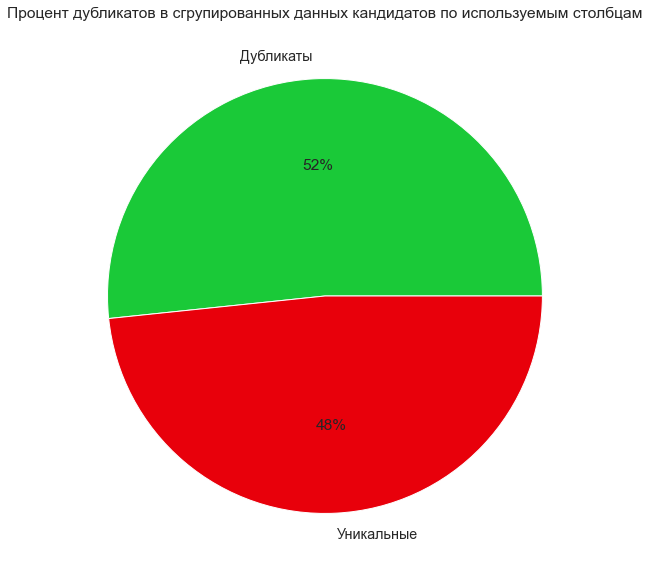

In [12]:
num_duplicates_grouped = grouped_table_candidates_features.duplicated(['Position', 'Age', 'Employment', 'Shedule', 
                                                                       'CandidateRegion', 'Langs', 'Sex', 'Citizenship', 
                                                                       'DriverLicense', 'Skills'])\
                                                                                                .sum()
colors = sns.color_palette('bright')[2:4]
pie_plot_grouped = plt.pie([num_duplicates_grouped, grouped_table_candidates_features.shape[0] - num_duplicates_grouped], 
        labels = ['Дубликаты', 'Уникальные'], 
        colors = colors, autopct='%.0f%%')
plt.title('Процент дубликатов в сгрупированных данных кандидатов по используемым столбцам')
plt.savefig('pie_plot_grouped.png')

In [13]:
age_vs_target = data_candidates[['CandidateId', 'JobId', 'Age']]\
    .merge(grouped_with_ids_target.fillna(0.5), on=['CandidateId', 'JobId'])\
    .drop(columns=['CandidateId', 'JobId'])\
    .query('Age > 0 and Age < 100')

age_vs_target_for_barplot = age_vs_target.groupby('Age', as_index=False).agg({'target' : 'mean'})

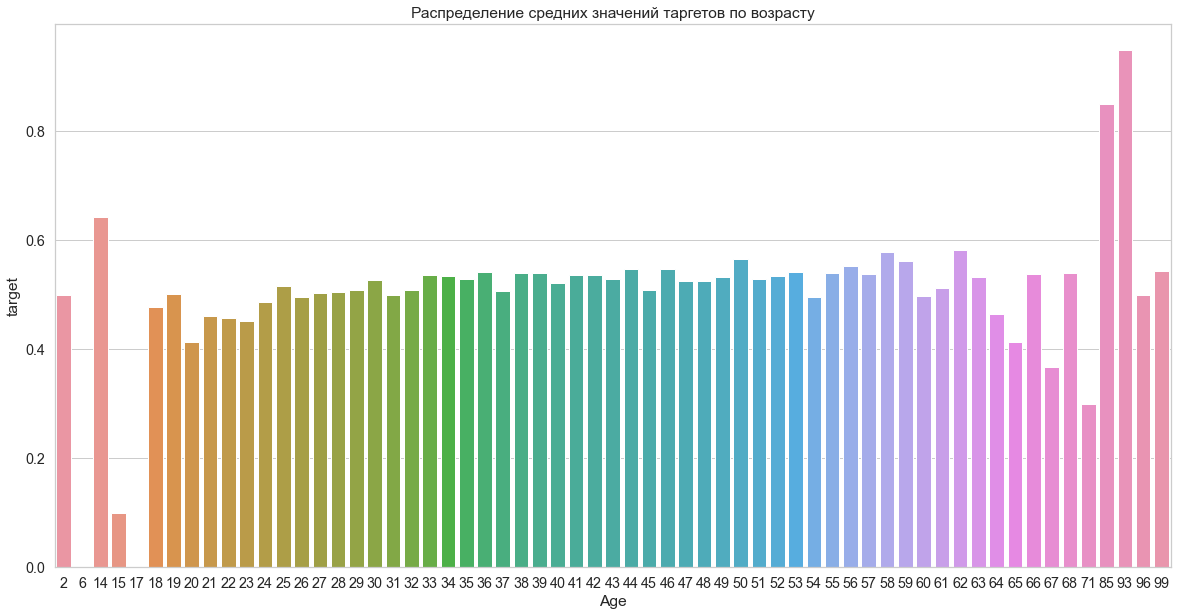

In [14]:
age_vs_target_plot = sns.barplot(data=age_vs_target_for_barplot, x='Age', y='target')
plt.title('Распределение средних значений таргетов по возрасту')
age_vs_target_plot.figure.savefig("age_vs_target_plot.png")

In [15]:
region_job_vs_target = data_candidates[['CandidateId', 'JobId', 'CandidateRegion', 'Position']]\
    .merge(grouped_with_ids_target, on=['CandidateId', 'JobId'])\
    .drop(columns = ['CandidateId', 'JobId'])
region_job_vs_target.CandidateRegion = ~(region_job_vs_target.CandidateRegion.isna())
region_job_vs_target.Position = ~(region_job_vs_target.Position.isna())
region_job_vs_target = region_job_vs_target.astype(float)
region_job_vs_target['num_not_null'] = region_job_vs_target.CandidateRegion + region_job_vs_target.Position
region_job_vs_target.drop(columns=['CandidateRegion', 'Position'], inplace=True)

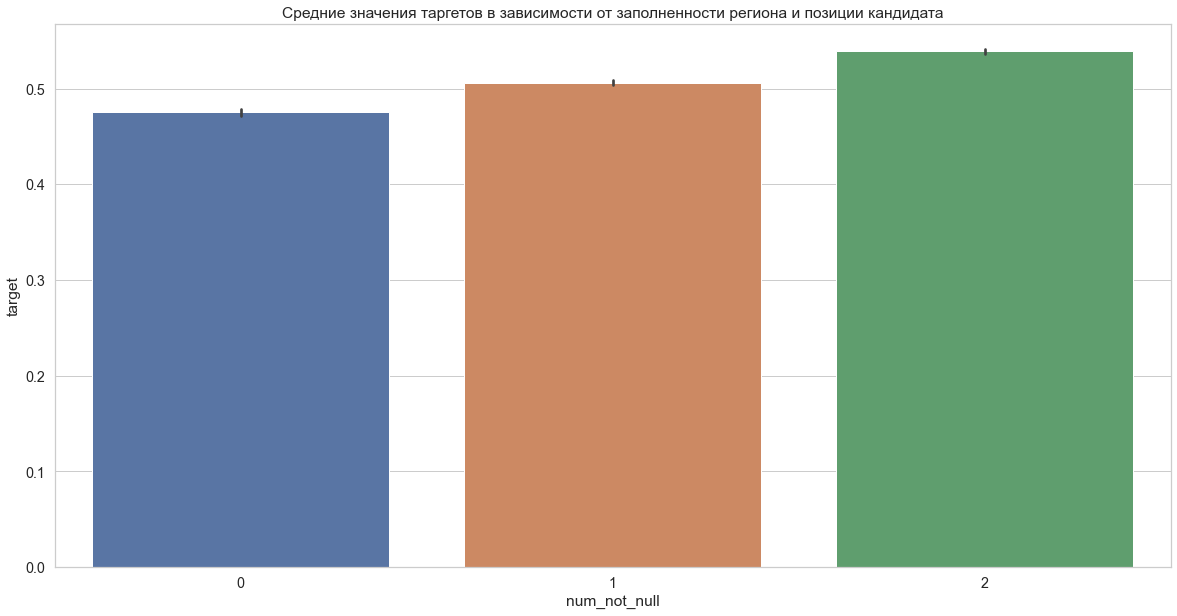

In [16]:
region_job_vs_target.groupby('num_not_null', as_index=False).agg({'target' : 'mean'})
region_job_vs_target.num_not_null = region_job_vs_target.num_not_null.astype(int)
region_job_vs_target_plot = sns.barplot(data=region_job_vs_target, x='num_not_null', y='target')
plt.title('Средние значения таргетов в зависимости от заполненности региона и позиции кандидата')
region_job_vs_target_plot.figure.savefig("region_job_vs_target_plot.png")

In [17]:
is_null_values = data_candidates.drop(columns=['Sex', 'Subway', 'DateCreated', 'CandidateStatusId', 'Status'])
is_null_values.index = [is_null_values.CandidateId, is_null_values.JobId]
is_null_values.drop(columns=['CandidateId', 'Position'], inplace=True)
num_notnull_vs_target = (~is_null_values.isna())\
                                                .astype(int)\
                                                .sum(axis=1)\
                                                .reset_index()\
                                                .rename(columns={0 : 'num_not_null'})\
                                                .merge(grouped_with_ids_target, on=['CandidateId', 'JobId'])\
                                                .drop(columns=['CandidateId', 'JobId'])\
                                                .groupby('num_not_null', as_index=False)\
                                                .agg({'target' : 'mean'})
# Можно вместо mean юзать median
num_notnull_vs_target

,num_not_null,target
0,3,0.431875
1,4,0.487101
2,5,0.468033
3,6,0.536317
4,7,0.525895
5,8,0.500794
6,9,0.547126
7,10,0.564624


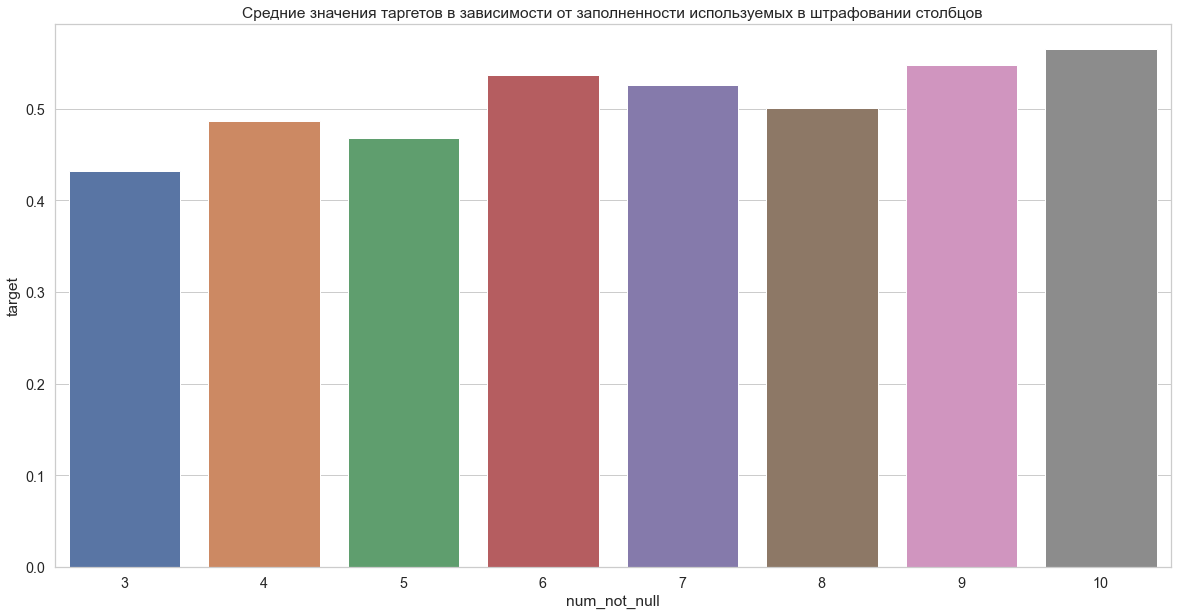

In [18]:
sns.barplot(data=num_notnull_vs_target, x='num_not_null', y='target')
num_notnull_vs_target_plot = plt.title('Средние значения таргетов в зависимости от заполненности используемых в штрафовании столбцов')
num_notnull_vs_target_plot.figure.savefig("num_notnull_vs_target_plot.png")